In [1]:
import pandapower as pp
import pandapower.networks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline

In [2]:
def rename(network):
    line_name = []
    bus_name = []
    for i in (network.line.index.values+1):
        line_name.append('line_'+str(i))
    
    for j in network.bus.name.values:
        bus_name.append('bus_'+str(j))
    
    # Rename lines: i.e. 'line_1'
    network.line.name=line_name
    
    # Rename bus: i.e. 'bus_1'
    network.bus.name=bus_name
    pass

In [3]:
# Initialize IEEE test network
net_39 = pandapower.networks.case39()
net_39

This pandapower network includes the following parameter tables:
   - bus (39 elements)
   - load (21 elements)
   - polynomial_cost (10 elements)
   - gen (9 elements)
   - line (34 elements)
   - trafo (12 elements)
   - bus_geodata (39 elements)
   - ext_grid (1 element)
 and the following results tables:
   - res_line (34 elements)
   - res_trafo (12 elements)
   - res_bus (39 elements)
   - res_gen (9 elements)
   - res_ext_grid (1 element)
   - res_load (21 elements)

In [4]:
rename(net_39)
net_39.line.head()

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,max_i_ka,df,parallel,type,in_service
0,line_1,None,0,1,1.0,4.165875,48.919275,1557.117675,1.004087,1.0,1,ol,True
1,line_2,None,0,38,1.0,1.190250,29.756250,1671.444477,1.673479,1.0,1,ol,True
2,line_3,None,1,2,1.0,1.547325,17.972775,573.194026,0.836740,1.0,1,ol,True
3,line_4,None,1,24,1.0,8.331750,10.236150,325.374525,0.836740,1.0,1,ol,True
4,line_5,None,2,3,1.0,1.547325,25.352325,493.410410,0.836740,1.0,1,ol,True


In [5]:
net_39.gen

,bus,controllable,in_service,max_p_kw,max_q_kvar,min_p_kw,min_q_kvar,name,p_kw,scaling,sn_kva,type,vm_pu
0,29,True,True,-0.0,400000.0,-1040000.0,140000.0,None,-250000.0,1.0,NaN,None,1.0499
1,31,True,True,-0.0,300000.0,-725000.0,150000.0,None,-650000.0,1.0,NaN,None,0.9841
2,32,True,True,-0.0,250000.0,-652000.0,0.0,None,-632000.0,1.0,NaN,None,0.9972
3,33,True,True,-0.0,167000.0,-508000.0,0.0,None,-508000.0,1.0,NaN,None,1.0123
4,34,True,True,-0.0,300000.0,-687000.0,-100000.0,None,-650000.0,1.0,NaN,None,1.0494
5,35,True,True,-0.0,240000.0,-580000.0,0.0,None,-560000.0,1.0,NaN,None,1.0636
6,36,True,True,-0.0,250000.0,-564000.0,0.0,None,-540000.0,1.0,NaN,None,1.0275
7,37,True,True,-0.0,300000.0,-865000.0,-150000.0,None,-830000.0,1.0,NaN,None,1.0265
8,38,True,True,-0.0,300000.0,-1100000.0,-100000.0,None,-1000000.0,1.0,NaN,None,1.0300


In [6]:
net_39.bus.head()

,in_service,max_vm_pu,min_vm_pu,name,type,vn_kv,zone
0,True,1.06,0.94,bus_1,b,345.0,2
1,True,1.06,0.94,bus_2,b,345.0,2
2,True,1.06,0.94,bus_3,b,345.0,2
3,True,1.06,0.94,bus_4,b,345.0,1
4,True,1.06,0.94,bus_5,b,345.0,1


In [9]:
pp.runpp(net_39)
net_39

This pandapower network includes the following parameter tables:
   - bus (39 elements)
   - load (21 elements)
   - polynomial_cost (10 elements)
   - gen (9 elements)
   - line (34 elements)
   - trafo (12 elements)
   - bus_geodata (39 elements)
   - ext_grid (1 element)
 and the following results tables:
   - res_line (34 elements)
   - res_trafo (12 elements)
   - res_bus (39 elements)
   - res_gen (9 elements)
   - res_ext_grid (1 element)
   - res_load (21 elements)

In [10]:
net_39.res_bus.head()

,vm_pu,va_degree,p_kw,q_kvar
0,1.039384,-13.536602,97600.0,44200.0
1,1.048494,-9.785267,0.0,0.0
2,1.030708,-12.276384,322000.0,2400.0
3,1.004460,-12.626734,500000.0,184000.0
4,1.006006,-11.192339,0.0,0.0


In [11]:
net_39.res_line.head()

,p_from_kw,q_from_kvar,p_to_kw,q_to_kvar,pl_kw,ql_kvar,i_from_ka,i_to_ka,i_ka,loading_percent
0,-173699.968353,-40307.333418,174677.679494,-24357.905613,977.711141,-64665.239032,0.287100,0.281497,0.287100,28.593122
1,76099.968353,-3892.666582,-76033.949144,-74752.541524,66.019208,-78645.208106,0.122686,0.173239,0.173239,10.352039
2,319914.587166,88586.563724,-318579.541911,-100878.939507,1335.045255,-12292.375784,0.529823,0.542565,0.542565,64.842795
3,-244592.266659,82973.576320,248928.896793,-93837.355150,4336.630133,-10863.778830,0.412240,0.420913,0.420913,50.303984
4,37339.617644,113064.517040,-37131.889918,-132590.249252,207.727726,-19525.732212,0.193326,0.229401,0.229401,27.416027


In [33]:
net_39.load.p_kw

0       97600.0
1      322000.0
2      500000.0
3      233800.0
4      522000.0
5        6500.0
6        8530.0
7      320000.0
8      329000.0
9      158000.0
10     680000.0
11     274000.0
12     247500.0
13     308600.0
14     224000.0
15     139000.0
16     281000.0
17     206000.0
18     283500.0
19       9200.0
20    1104000.0
Name: p_kw, dtype: float64

In [53]:
net_39.res_bus.loc[pmu_location]

,vm_pu,va_degree,p_kw,q_kvar
22,1.045145,-3.381276,247500.0,84600.0
25,1.052561,-9.438770,139000.0,17000.0
28,1.050115,-3.169874,283500.0,26900.0


## Randomly sampled loads

In [128]:
def record_pmu_data(network, pmu_index):
    
    pmu_0_va_degree.append(network.res_bus.loc[pmu_index[0]].va_degree)
    pmu_0_vm_pu.append(network.res_bus.loc[pmu_index[0]].vm_pu)
    
    pmu_1_va_degree.append(network.res_bus.loc[pmu_index[1]].va_degree)
    pmu_1_vm_pu.append(network.res_bus.loc[pmu_index[1]].vm_pu)
    
    pmu_2_va_degree.append(network.res_bus.loc[pmu_index[2]].va_degree)
    pmu_2_vm_pu.append(network.res_bus.loc[pmu_index[2]].vm_pu)

def change_loads(network, loads_at_time_t):
    for i in range(network.load.shape[0]):
        network.load.p_kw[i] = loads_at_time_t[i]

In [129]:
pmu_location = [23, 26, 29]
pmu_index = [i-1 for i in pmu_location] # To conform with data format in the case, 0-start

In [164]:
random_seed = 100
np.random.seed(random_seed)

# Create normally distributed loads

mean = 300000
std = 10000
samples_per_second = 60
loads = pd.DataFrame()
for i in range(net_39.load.shape[0]):
    name = 'load_'+str(i)
    loads[name] = np.random.normal(loc=mean, scale=std, size=samples_per_second)
    
pmu_0_va_degree = []
pmu_1_va_degree = []
pmu_2_va_degree = []

pmu_0_vm_pu = []
pmu_1_vm_pu = []
pmu_2_vm_pu = []

pmu_data = pd.DataFrame()
for i in range(len(pmu_location)):
    pmu_data['pmu_'+str(i)+'_va_degree'] = []
    pmu_data['pmu_'+str(i)+'_vm_pu'] = []

In [165]:
print('PMU location: ', pmu_location)

# For a PMU with 60 sps
for t in range(samples_per_second):
    change_loads(net_39, loads.loc[t])
    pp.runpp(net_39)
    record_pmu_data(net_39, pmu_index)

pmu_data = pd.DataFrame(list(zip(pmu_0_va_degree, pmu_0_vm_pu, pmu_1_va_degree, pmu_1_vm_pu, pmu_2_va_degree, pmu_2_vm_pu)), columns=pmu_data.columns)

PMU location:  [23, 26, 29]


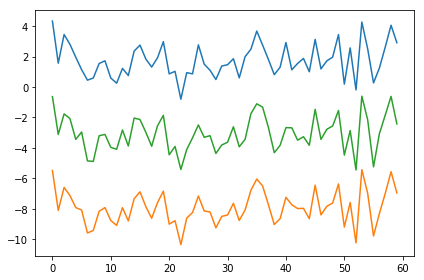

In [166]:
plt.plot(pmu_data.pmu_0_va_degree)
plt.plot(pmu_data.pmu_1_va_degree)
plt.plot(pmu_data.pmu_2_va_degree)
plt.tight_layout()

In [167]:
# Setting a line to in service or not
line_number = 24
net_39.line.in_service.loc[line_number-1] = False
net_39.line.loc[line_number-1]

name             line_24
std_type            None
from_bus              15
to_bus                23
length_km              1
r_ohm_per_km    0.357075
x_ohm_per_km     7.02248
c_nf_per_km      151.544
max_i_ka         1.00409
df                     1
parallel               1
type                  ol
in_service         False
Name: 23, dtype: object

In [168]:
for t in range(samples_per_second):
    change_loads(net_39, loads.loc[t])
    pp.runpp(net_39)
    record_pmu_data(net_39, pmu_index)
    
pmu_data = pd.DataFrame(list(zip(pmu_0_va_degree, pmu_0_vm_pu, pmu_1_va_degree, pmu_1_vm_pu, pmu_2_va_degree, pmu_2_vm_pu)), columns=pmu_data.columns)

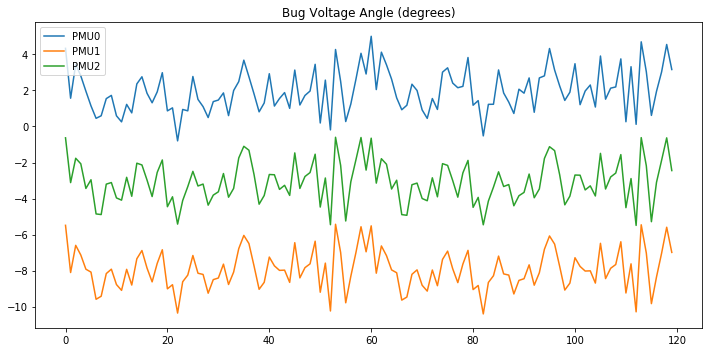

In [169]:
plt.figure(figsize=[10,5])
plt.title('Bug Voltage Angle (degrees)')
plt.plot(pmu_data.pmu_0_va_degree)
plt.plot(pmu_data.pmu_1_va_degree)
plt.plot(pmu_data.pmu_2_va_degree)
#plt.vlines(x=60,ymin=-60, ymax=40,colors='r')
#plt.vlines(x=120,ymin=-60, ymax=40,colors='r')
plt.legend(['PMU0', 'PMU1', 'PMU2'])
plt.tight_layout()

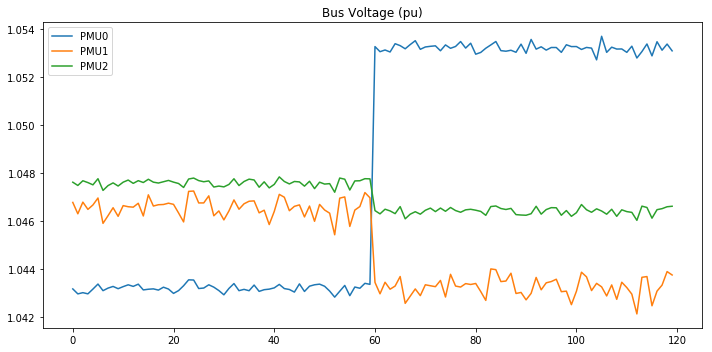

In [170]:
plt.figure(figsize=[10,5])
plt.title('Bus Voltage (pu)')
plt.plot(pmu_data.pmu_0_vm_pu)
plt.plot(pmu_data.pmu_1_vm_pu)
plt.plot(pmu_data.pmu_2_vm_pu)
#plt.vlines(x=60,ymin=-60, ymax=40,colors='r')
#plt.vlines(x=120,ymin=-60, ymax=40,colors='r')
plt.legend(['PMU0', 'PMU1', 'PMU2'])
plt.tight_layout()

## Obtain PMU data

Three PMUs: Bus 23, 26, 29 (for example) <br>
Quantity: Voltage angle

In [151]:
fft_pmu0 = np.fft.fft(pmu_data.pmu_0_va_degree)
fft_pmu1 = np.fft.fft(np.asarray(pmu_data.pmu_1_va_degree)-np.asarray(pmu_data.pmu_0_va_degree))
fft_pmu2 = np.fft.fft(np.asarray(pmu_data.pmu_2_va_degree)-np.asarray(pmu_data.pmu_0_va_degree))


imag_pmu0 = fft_pmu0.imag.tolist()
imag_pmu1 = fft_pmu1.imag.tolist()
imag_pmu2 = fft_pmu2.imag.tolist()

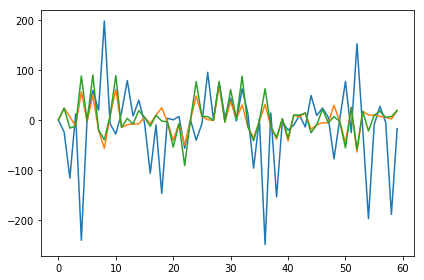

In [172]:
plt.plot(imag_pmu0[60:])
plt.plot(imag_pmu1[60:])
plt.plot(imag_pmu2[60:])
plt.tight_layout()

In [180]:
for i in range(len(imag_pmu0)0-1):
    print(imag_pmu0[i+1]-imag_pmu0[i])

17.126311552215416
170.93284031786877
-183.48188729028493
-31.81734906078483
36.402138849637524
187.40990800546638
-179.46265491468597
-169.25898979744207
177.4026691480162
-102.24165501785276
75.17568979582825
79.34125683340915
-83.03280107221002
-18.44322938736527
14.923395597517944
-40.05611896284652
63.02383649728765
-23.459867906909917
19.618740889865226
10.145398998061008
-16.960915430305427
150.08850868378778
-167.31151269485014
262.38775694037514
-250.36877929062703
97.87522844454568
-109.1788104139628
-49.07609907885398
64.16978081586747
-45.43658930576093
39.030809646842826
-70.0147760646478
73.5768424529088
-94.21862565572262
102.43007559417244
32.86947495102653
-40.603836440574725
56.7985029308487
-63.483304766044434
6.766635442051646
-3.0842676291295774
149.6979939073859
-136.50371259500469
96.39882054815712
-100.86422434485695
-44.80900167177922
31.67945682177095
-70.91266878273936
63.85641850780081
42.943145455589146
-20.682442731078794
-204.63507878127135
177.5436534906

IndexError: list index out of range